## <strong> <a style="color:blue">Elastic Net Model Accuracy Comparison </a> </strong> 

---

|  |  |
|:---|:---|
|**Reading Time** |  10 minutes |
|**Packages used** | Defined with relevant DocStrings within repository   |
|**Model Hyperparameter** | Read tuned model hyperparameter stored in the directory ./model/output/ElasticNet|
|**Outcome** | Comparison of the model accuracy on the real stock price history | 

---

In [1]:
import os
import pickle

import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import datetime as dt
import tulipy as ti

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore") # just to remove clutter in the notebook

from pandas.tseries.offsets import BDay
from datetime import date, datetime, timedelta
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
os.chdir("..")

### <strong> <a style="color:blue">1. Import methods defined in the directory </a> </strong> 

---

In [3]:
from model.utils.pre_processing import create_features_and_target_split, standardize_and_limit_outliers_returns, get_features_for_multi_step_forecasting, add_technical_indicators

### <strong> <a style="color:blue">2. Download data </a> </strong> 

---

In [4]:
ticker = "SBIN.NS"
Stock = "SBI"
end_date = datetime.today()
start_date = date(2016, 1, 1)
df_hist = yf.download(ticker, start=start_date, end=end_date)
df_all_dates = pd.DataFrame(index=pd.bdate_range(start=start_date,end=end_date))
df_hist = pd.merge(df_all_dates, df_hist, how="left", left_index=True, right_index=True)
df_hist = df_hist.fillna(method='ffill')

[*********************100%***********************]  1 of 1 completed


### <strong> <a style="color:blue">3. Define training data end date, validation period end date and number of past daily returns that are used as features to predict next day's return </a> </strong> 

---

In [5]:
param = {'training_end': end_date - timedelta(seconds=2 * 365.2425 * 24 * 60 * 60),
             'validation_end': end_date - timedelta(seconds=1 * 365.2425 * 24 * 60 * 60),
             'past_day_returns_for_predicting': 21}

### <strong> <a style="color:blue">4. Add technical indicators method creates extra momenetum based technical indicators which will be used as features along with usual past daily returns as features </a> </strong> 

---

In [6]:
df_hist = add_technical_indicators(df_hist)
df_hist['daily_returns'] = df_hist['Adj Close'].pct_change()
df_hist = df_hist.dropna()
dt_model = create_features_and_target_split(pd.DataFrame(df_hist['daily_returns']),
                                                param['past_day_returns_for_predicting'])
dt_model = pd.merge(dt_model, df_hist, how="left", left_index=True, right_index=True)
technical_indicator_features = ['RSI', 'MACD', 'UpperBollingerBand', 'LowerBollingerBand']

### <strong> <a style="color:blue">4. Get training dataset features, scaler used to transform variables and finally train model by using already tuned hyper parameters </a> </strong> 

---

In [7]:
X_train, Y_train, X_val, Y_val, scaler = standardize_and_limit_outliers_returns(dt_model, param['past_day_returns_for_predicting'], technical_indicator_features, **param)

In [8]:
model_path = os.getcwd() + "/model/output/ElasticNet/" + f"{Stock}.pkl"
# read already trained model for reading optimized hyper parameter
with open(model_path, 'rb') as f:
    model_hyper = pickle.load(f)
model = ElasticNet(alpha=model_hyper.alpha, l1_ratio=model_hyper.l1_ratio)
model.fit(X_train, Y_train)

ElasticNet(alpha=0.0001, l1_ratio=0.6)

In [9]:
dt_model['actual_returns'] = dt_model['Adj Close'].pct_change()
dt_model = dt_model.dropna()
dt_model['predicted_returns'] = ""

In [10]:
df_training = dt_model[dt_model.index <= param['training_end']]
df_test = dt_model[dt_model.index > param['validation_end']]

### <strong> <a style="color:blue">5. Plotting the prediction based on updating features on a daily basis. Issue in this approach is that we are using updated realized new features to predict next day return, thus, we will not know everything at time t=0.</a> </strong> 

---


In [11]:
rol_freq = param['past_day_returns_for_predicting']
for i in range(0, len(df_test) - 1):
    features_ls = np.concatenate((df_test.iloc[i, :rol_freq].values, df_test.iloc[i][technical_indicator_features].values))
    features_ls = features_ls.reshape(-1,1)
    new_scaled_ls = scaler.transform(features_ls.T)
    predicted_return = model.predict(new_scaled_ls)[0]
    # current features are predicting next day return
    df_test.iloc[i+1, df_test.columns.get_loc('predicted_returns')] = predicted_return

In [12]:
df_test_subset = df_test[['actual_returns', 'predicted_returns']]
df_test_subset['Actual'] = ""
df_test_subset['Predicted'] = ""

In [13]:
st_ind = df_test_subset.index[0]
df_test_subset.loc[st_ind, 'Actual'] = 100
df_test_subset.loc[st_ind, 'Predicted'] = 100

In [14]:
i = 1
for ind in df_test_subset.index[1:]:
    df_test_subset.loc[ind,'Actual'] = df_test_subset.iloc[i - 1]['Actual'] * (1 + df_test_subset.iloc[i]['actual_returns'])
    df_test_subset.loc[ind,'Predicted'] = df_test_subset.iloc[i - 1]['Predicted'] * (1 + df_test_subset.iloc[i]['predicted_returns'])
    i+=1

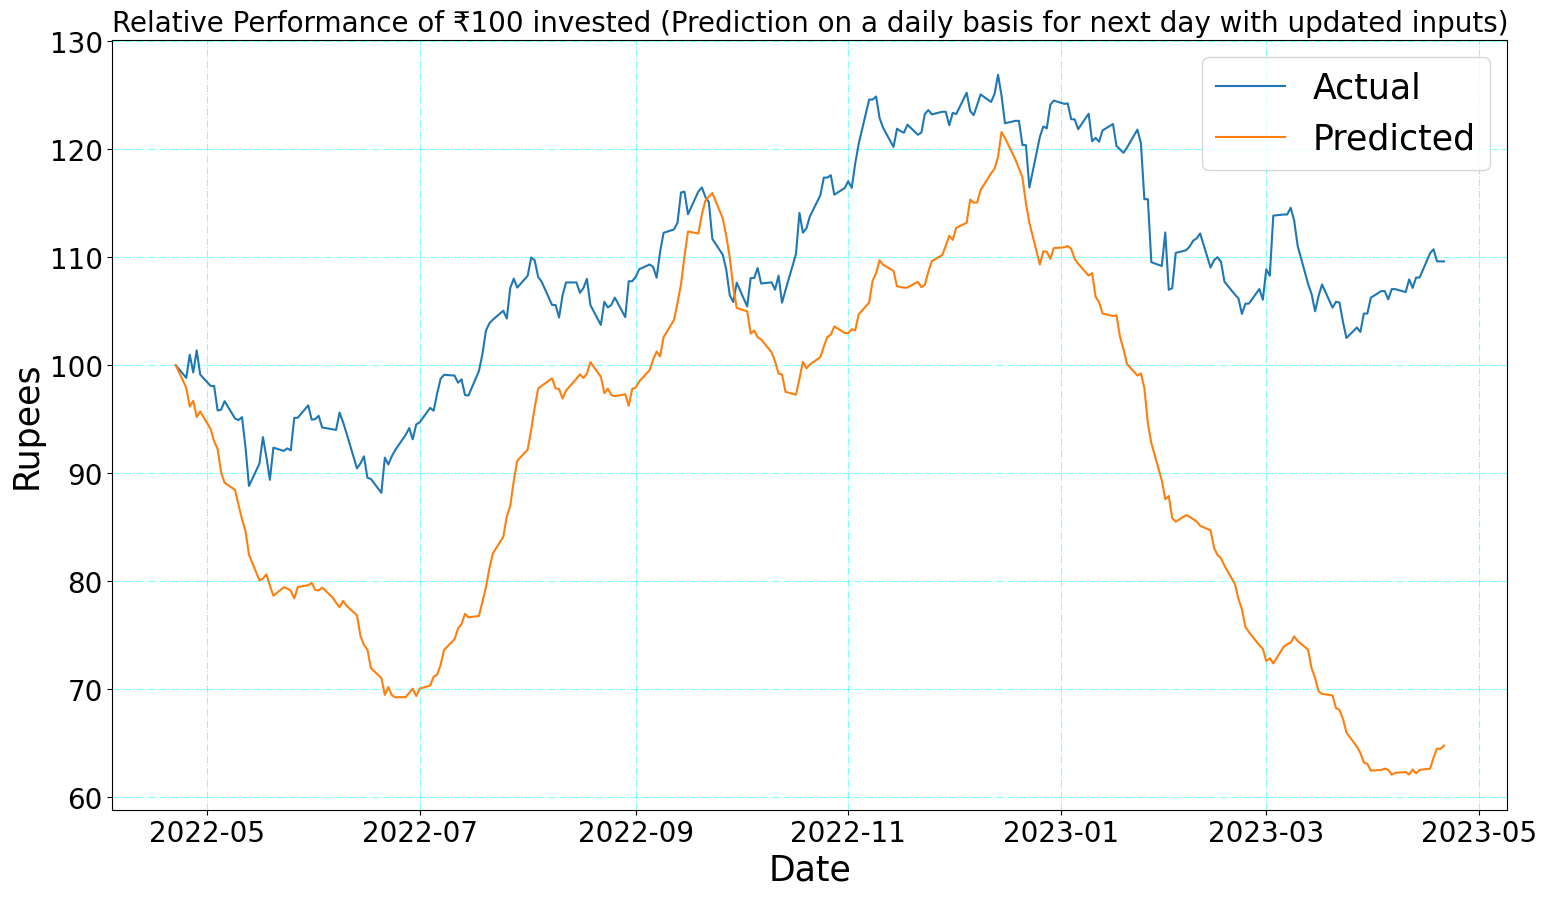

In [15]:
fig, ax = plt.subplots(figsize = (18,10))
ax.plot(df_test_subset.index, df_test_subset['Actual'], label="Actual")
ax.plot(df_test_subset.index, df_test_subset['Predicted'], label="Predicted")

ax.set_title("Relative Performance of ₹100 invested (Prediction on a daily basis for next day with updated inputs)", fontsize=20, color="black")
ax.set_xlabel("Date", fontsize=25, color="black")
ax.set_ylabel("Rupees", fontsize=25, color="black")
ax.tick_params(axis='both', labelsize=20)

ax.set_frame_on(True)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.grid(b=True, color="aqua", alpha=0.5, linestyle='-.')
plt.legend(loc='upper right', prop={'size': 25})
# plt.style.use('classic')
plt.show()


### <strong> <a style="color:blue"> 6. Better approach is to do multi-step forecasting which uses the predicted variables as an input features, thus, making all future prediction at time t=0 </a> </strong> 

---

In [16]:
df_test_multi_step = dt_model[dt_model.index > param['validation_end']]
df_test_multi_step['Predicted Adj Close'] = df_test_multi_step['Adj Close'] # will update it while looping
end_date = dt.datetime.today()
period_start_date = end_date - dt.timedelta(days=30)

In [17]:
rol_freq = param['past_day_returns_for_predicting']
predicted_dates = pd.bdate_range(start=period_start_date,end=end_date)

In [18]:
for date in predicted_dates[:-1]:
    price_trend_before_date = pd.DataFrame(df_test_multi_step.loc[df_test_multi_step.index < date, 'Predicted Adj Close'])
    df = price_trend_before_date.copy()
    features_ls = get_features_for_multi_step_forecasting(df, rol_freq, technical_indicator_features)
    features_ls = features_ls.reshape(-1,1)
    new_scaled_ls = scaler.transform(features_ls.T)
    predicted_return = model.predict(new_scaled_ls)[0]
    next_working_date = (date + BDay(1)).replace(hour=0, minute=0, second=0, microsecond=0)
    date = date.replace(hour=0, minute=0, second=0, microsecond=0)
    df_test_multi_step.loc[next_working_date, 'predicted_returns'] = predicted_return
    df_test_multi_step.loc[next_working_date, 'Predicted Adj Close'] = (1 + predicted_return) * df_test_multi_step.loc[date, 'Predicted Adj Close']

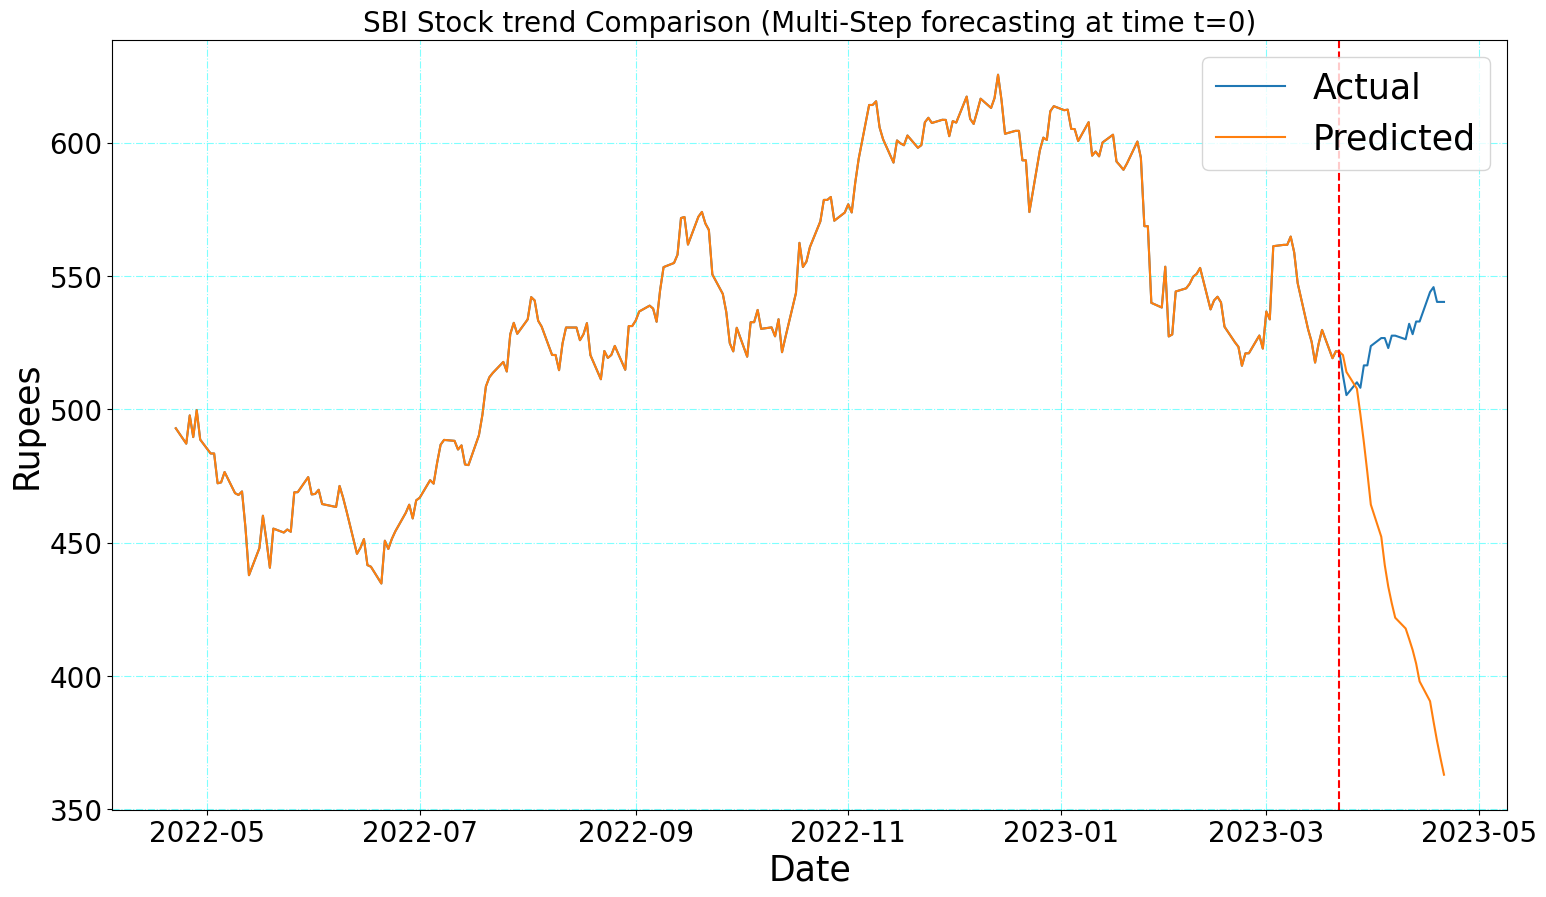

In [19]:
fig, ax = plt.subplots(figsize = (18,10))
ax.plot(df_test_multi_step.index, df_test_multi_step['Adj Close'], label="Actual")
ax.plot(df_test_multi_step.index, df_test_multi_step['Predicted Adj Close'], label="Predicted")

ax.set_title(f"{Stock} Stock trend Comparison (Multi-Step forecasting at time t=0)", fontsize=20, color="black")
ax.set_xlabel("Date", fontsize=25, color="black")
ax.set_ylabel("Rupees", fontsize=25, color="black")
ax.tick_params(axis='both', labelsize=20)

ax.set_frame_on(True)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.grid(b=True, color="aqua", alpha=0.5, linestyle='-.')
plt.legend(loc='upper right', prop={'size': 25})
plt.axvline(x=predicted_dates[0], color="r", linestyle="--")
plt.show()